In [161]:
import pandas as pd
import wget
import numpy as np
import platform
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
wget.download(url)


'car_fuel_efficiency.csv'

In [162]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [163]:
df.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [164]:
df = df[['engine_displacement', 'horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']]

In [165]:
df['fuel_efficiency_mpg'].describe()

count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64

In [166]:
df['fuel_efficiency_mpg'].skew()

-0.012062219273507929

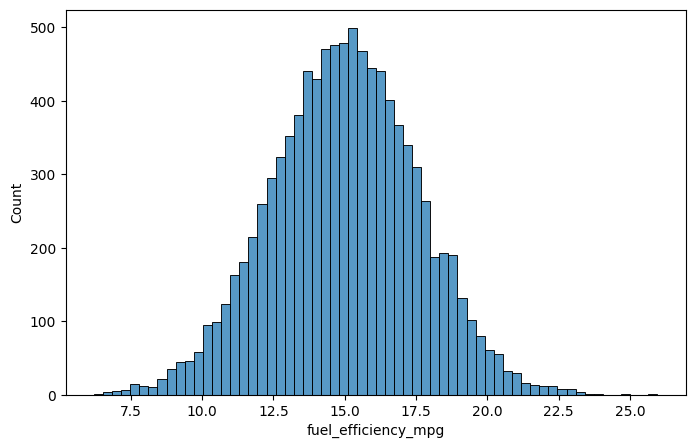

In [167]:
plt.figure(figsize=(8,5))
sns.histplot(df['fuel_efficiency_mpg'])
plt.show()

In [168]:
fuel_efficiency_mpg = np.log1p(df.fuel_efficiency_mpg)

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

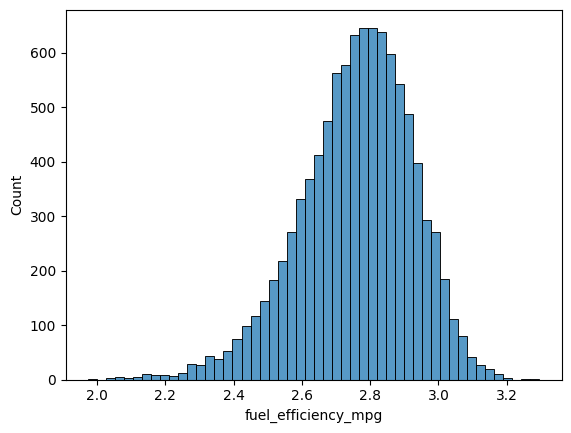

In [169]:
sns.histplot(fuel_efficiency_mpg, bins=50)

In [170]:
#It has left tail

In [171]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

Q1: horsepower is missing values

In [172]:
df['horsepower'].median()

149.0

Q2: the median of horsepower column is 149

In [173]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [174]:
n

9704

In [175]:
n_val, n_test, n_train

(1940, 1940, 5824)

In [176]:
idx = np.arange(n)

In [177]:
np.random.seed(42)
np.random.shuffle(idx)

In [178]:
df_train = df.iloc[idx[:n_train]].copy()
df_val = df.iloc[idx[n_train:n_train+n_val]].copy()
df_test = df.iloc[idx[n_train+n_val:]].copy()

In [179]:
df_train.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822
1688,150,206.0,3748.164469,2015,11.818843
6217,300,111.0,2135.716359,2006,19.402209


In [180]:
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [181]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [182]:
y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

In [183]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [184]:
len(y_train)

5824

In [185]:
#option 1: filling in the horsepower column with 0

In [186]:
df_train.isnull().sum()

engine_displacement      0
horsepower             429
vehicle_weight           0
model_year               0
dtype: int64

In [187]:
def prepare_data(df, replace_value):
    df_num = df
    df_num['horsepower'] = df_num['horsepower'].fillna(replace_value)
    X = df_num.values
    return X


In [188]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [189]:
df_train['horsepower'].mean()

149.54476367006487

In [190]:
X_train = prepare_data(df_train, 0)

In [191]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [192]:
X_train = prepare_data(df_train, 0)
w0, w = train_linear_regression(X_train, y_train)
X_val = prepare_data(df_val, 0)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

0.04

Training linear regression with mean

In [193]:
df_train['horsepower'].mean()

138.52918956043956

In [194]:
X_train = prepare_data(df_train, df_train['horsepower'].mean())
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_data(df_val, df_train['horsepower'].mean())
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

0.04

Both models give the same RMSE score

Regularized model

In [195]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [196]:
X_train = prepare_data(df_train, 0)
w0, w = train_linear_regression_reg(X_train, y_train, r=0)
X_val = prepare_data(df_val, 0)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.03997925782577713

In [197]:
X_train = prepare_data(df_train, 0)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_data(df_val, 0)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.039977872016356185

In [198]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

best_rmse =float('inf')
best_r = None
X_train = prepare_data(df_train, 0)
X_val = prepare_data(df_val, 0)

for r in r_values:
    
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    y_pred = w0 + X_val.dot(w)
    current_rmse = rmse(y_val, y_pred)
    print(f"r = {r}, RMSE = {current_rmse:.6f}")

    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_r = r

print("\nBest result:")
print(f"r = {best_r}, RMSE = {round(best_rmse,2):.6f}")

r = 0, RMSE = 0.039979
r = 0.01, RMSE = 0.039978
r = 0.1, RMSE = 0.040509
r = 1, RMSE = 0.041354
r = 5, RMSE = 0.041506
r = 10, RMSE = 0.041527
r = 100, RMSE = 0.041546

Best result:
r = 0.01, RMSE = 0.040000


Question 5

In [199]:
scores_list = list()
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]].copy()
    df_val = df.iloc[idx[n_train:n_train+n_val]].copy()
    df_test = df.iloc[idx[n_train+n_val:]].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train['fuel_efficiency_mpg'].values)
    y_val = np.log1p(df_val['fuel_efficiency_mpg'].values)
    y_test = np.log1p(df_test['fuel_efficiency_mpg'].values)

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']
    
    X_train = prepare_data(df_train, 0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_data(df_val, 0)
    y_pred = w0 + X_val.dot(w)
    scores_list.append(rmse(y_val, y_pred))
    
print(f"The standard deviation of all the scores is: {round(np.std(scores_list), 3)}")

The standard deviation of all the scores is: 0.001


Question 6

In [154]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train+n_val]].copy()
df_val = df.iloc[n_train:n_train+n_val].copy()
df_test = df.iloc[idx[n_train+n_val:]].copy()

df_train_full = pd.concat([df_train, df_val])

df_train_val = df_train_full.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_full = df_train_full.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values


del df_train_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [155]:
X_train_full = prepare_data(df_train_val, 0)
w_0_train_val, w_train_val = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)

X_test = prepare_data(df_test, 0)
y_pred_test = w_0_train_val + X_test.dot(w_train_val)

rmse(y_test, y_pred_test)

0.5155092196601588